In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd_data = pd.read_csv('0612_island_IM.csv', nrows=5000)
# 重命名数据列
pd_data.columns = ['Time', 'theta', 'Id', 'Idrms', 'Iq', 'Iqrms', 'Ws','p_test', 'q_test', 'Tmpu', 'Vd', 'Vdrms', 'Vq', 'Vqrms', 'Ia', 'Ib', 'Ic',  'ph', 'qh', 'Wr', 'Te', 'Va', 'Vb', 'Vc']

# 定义参数
rs = 2.0110e-2
xs = 1.0448e-1
xmu = 9.0424
rr = 4.5768e-2
xr = 1.0448e-1
Omega_b = 377
Hm = 0.075352957

x0 = xs + xmu
xp = xs + xr * xmu / (xr + xmu)
T0p = (xr + xmu) / (Omega_b * rr)



# 计算edp和eqp的值，这里是用dq的实时peak值来计算的，前面的功率是rms计算的，或者dq的peak乘以1.5也是一样的

In [129]:
pd_data['edp'] = pd_data['Vdrms'] - (rs * pd_data['Idrms'] - xp * pd_data['Iqrms'])
pd_data['eqp'] = pd_data['Vqrms'] - (rs * pd_data['Iqrms'] + xp * pd_data['Idrms'])
# pd_data['edp'] = pd_data['Vd'] - (rs * pd_data['Id'] - xp * pd_data['Iq'])
# pd_data['eqp'] = pd_data['Vq'] - (rs * pd_data['Iq'] + xp * pd_data['Id'])

In [130]:
# pd_data[['eqp','edp']].plot()

# 验证电磁转矩的公式Te = edp * id + eqp * iq, 表格里的Te数据是标幺值，基准值为0.16, 所有计算均为rms值，如果是peak值则有名值是需要乘以0.106的

count    5000.000000
mean        0.000081
std         0.000368
min        -0.004764
25%        -0.000023
50%         0.000163
75%         0.000210
max         0.001202
dtype: float64

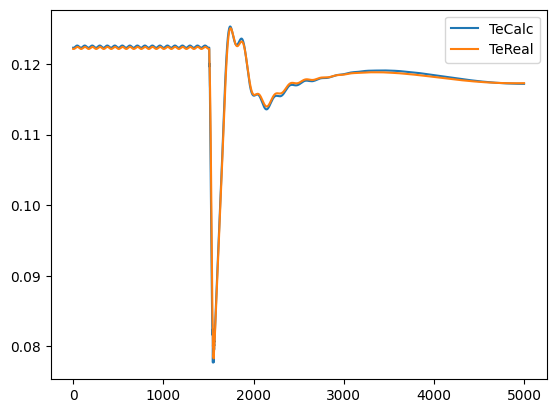

In [131]:
pd_data['TeCalc'] = (pd_data['edp'] * pd_data['Idrms'] + pd_data['eqp'] * pd_data['Iqrms']) # 0.1061为基准值，这里计算的有名值，csv文件里面获取的Te是pu值
pd_data['TeReal'] = - pd_data['Te'] * 0.159
pd_data[['TeCalc','TeReal']].plot()
(pd_data['TeCalc']-pd_data['TeReal']).describe()
# (pd_data['TeCalc']-pd_data['TeReal']).plot()

# 验证Tm和Te的公式在Hm=0.7...的情况下是否正确,此处都是标幺值计算，Te和Tmpu都已经转换为了标幺值，Wr是转子侧转速（pu）, Ws的基准值是377 rad/s

In [132]:
# 计算滑差 σ
pd_data['sigma'] = 1 - pd_data['Wr']

# 计算滑差的导数 σ_dot
sigma_dt = (pd_data['sigma'][2:].to_numpy() - pd_data['sigma'][:-2].to_numpy()) / (pd_data['Time'][2] - pd_data['Time'][0])
pd_data['sigma_dot'] = [sigma_dt[0]] + list(sigma_dt) + [sigma_dt[-1]]

# 计算公式
pd_data['sigma_Calc'] = (pd_data['Te'] - pd_data['Tmpu']) / (2 * Hm)

count    5000.000000
mean        0.000040
std         0.002394
min        -0.010363
25%        -0.000085
50%         0.000012
75%         0.000046
max         0.043573
dtype: float64

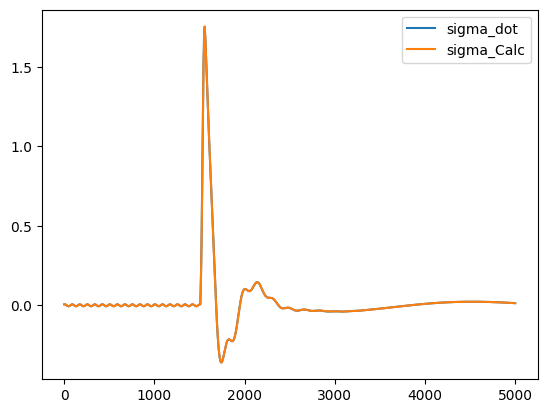

In [133]:
pd_data[['sigma_dot','sigma_Calc']].plot()
(pd_data['sigma_dot']-pd_data['sigma_Calc']).describe()

count    5000.000000
mean        0.000040
std         0.002394
min        -0.010363
25%        -0.000085
50%         0.000012
75%         0.000046
max         0.043573
dtype: float64

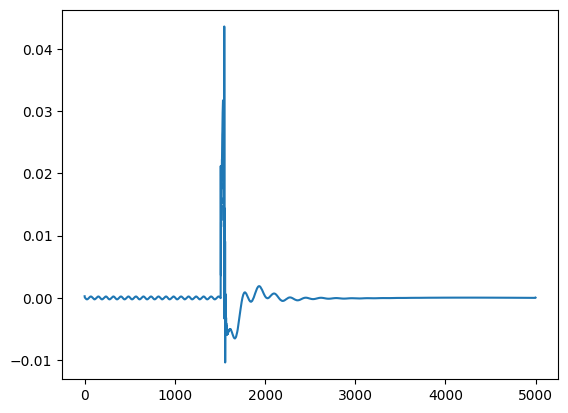

In [134]:
(pd_data['sigma_dot']-pd_data['sigma_Calc']).plot()
(pd_data['sigma_dot']-pd_data['sigma_Calc']).describe()

# 接下来验证edp和eqp的微分方程部分，书中公式15.62
## 前面的验证证明了id iq vd vq Te 和 Tm的量测数据均没有问题， 计算出来的edp和eqp都和数据对应得上，因此不存在edp和eqp的计算错误问题 （0612更新：这里其实不好说，edp和eqp在计算Te的时候基本没涉及微分部分）
## 参数方面rs xs xmu xr均没有问题，还剩rr没有验证

In [135]:
# # 计算数据求出的导数 (numerical derivatives)
edp_dt = (pd_data['edp'][2:].to_numpy() - pd_data['edp'][:-2].to_numpy()) / (pd_data['Time'][2] - pd_data['Time'][0])
eqp_dt = (pd_data['eqp'][2:].to_numpy() - pd_data['eqp'][:-2].to_numpy()) / (pd_data['Time'][2] - pd_data['Time'][0])

pd_data['edp_dot_data'] = [edp_dt[0]] + list(edp_dt) + [edp_dt[-1]]
pd_data['eqp_dot_data'] = [eqp_dt[0]] + list(eqp_dt) + [eqp_dt[-1]]

# pd_data['edp_dot_data'].plot()
# pd_data['eqp_dot_data'].plot()

count    5000.000000
mean        2.020668
std         3.807552
min       -65.217538
25%         1.263483
50%         1.672101
75%         2.538575
max       132.620742
dtype: float64

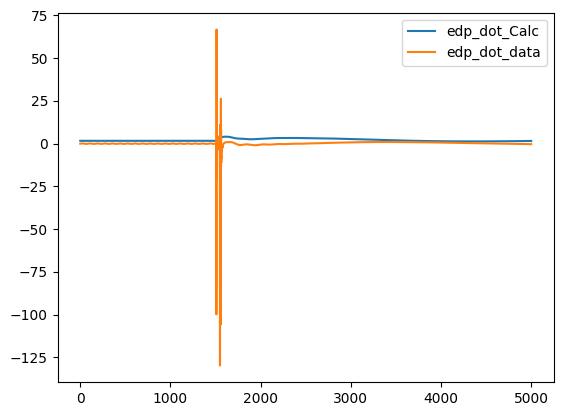

In [136]:
# 通过公式计算的内容
Omega_b = 377
pd_data['edp_dot_Calc'] = Omega_b * pd_data['sigma'] * pd_data['eqp'] - ( pd_data['edp'] + (x0 - xp) * pd_data['Iqrms']) / T0p
pd_data['eqp_dot_Calc'] = -Omega_b * pd_data['sigma'] * pd_data['edp'] - (pd_data['eqp'] - (x0 - xp) * pd_data['Idrms']) / T0p
pd_data[['edp_dot_Calc', 'edp_dot_data']].plot()
(pd_data['edp_dot_Calc']-pd_data['edp_dot_data']).describe()

In [137]:
pd_data['edp_dot_Calc1'] = Omega_b * pd_data['sigma'] * pd_data['eqp'] - ( pd_data['edp'] + (x0 - xp) * pd_data['Iqrms']) / T0p
pd_data['edp_dot_Calc2'] =  - ( pd_data['edp'] + (x0 - xp) * pd_data['Iqrms']) / T0p
pd_data['edp_dot_Calc3'] = Omega_b * pd_data['sigma'] * pd_data['eqp']
# (pd_data['edp_dot_Calc1']).plot()
# (pd_data[['edp_dot_Calc1','edp_dot_Calc2','edp_dot_Calc3']]).plot()

<Axes: >

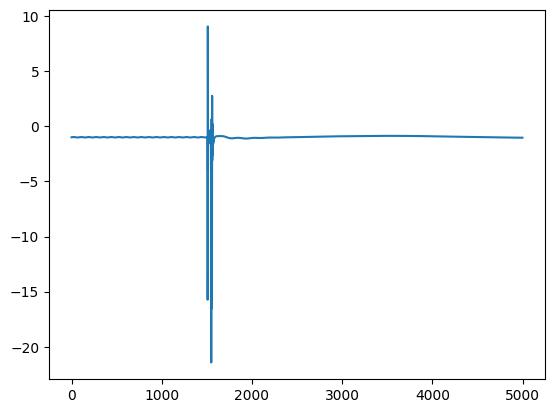

In [138]:
T0p_daoshu = (pd_data['edp_dot_data'] - Omega_b * pd_data['sigma'] * pd_data['eqp']) / (Omega_b * pd_data['sigma'] * pd_data['eqp'])
T0p_daoshu.plot()

In [145]:
T0p_daoshu.describe()

count    5000.000000
mean       -0.990144
std         0.556333
min       -21.420934
25%        -1.015886
50%        -0.984289
75%        -0.917723
max         9.045812
dtype: float64

count    5000.000000
mean        2.020668
std         3.807552
min       -65.217538
25%         1.263483
50%         1.672101
75%         2.538575
max       132.620742
dtype: float64

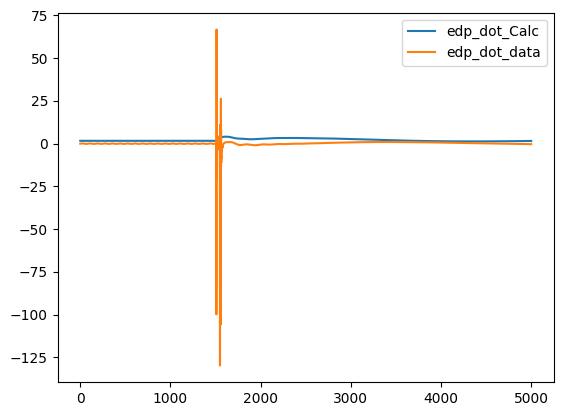

In [140]:
pd_data['edp_dot_Calc'] = Omega_b * pd_data['sigma'] * pd_data['eqp'] - ( pd_data['edp'] + (x0 - xp) * pd_data['Iqrms']) / T0p
pd_data[['edp_dot_Calc', 'edp_dot_data']].plot()
(pd_data['edp_dot_Calc']-pd_data['edp_dot_data']).describe()